# Library

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
# Others
import shutil
import random

# Load dataset

In [4]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/train",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/Bell_pepper/test",
    label_mode="categorical",
    class_names= ['Pepper bell Bacterial spot', 'Pepper bell healthy'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 4033 files belonging to 2 classes.
==========================Validation Data====================
Found 962 files belonging to 2 classes.


In [5]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("Dataset/Bell_pepper/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("Dataset/Bell_pepper/test",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 4033 images belonging to 2 classes.
Found 962 images belonging to 2 classes.


# List Resource

In [6]:
# Check GPU
!nvidia-smi

Wed May 24 15:49:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P0               29W /  N/A|   4456MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# Modelling Without Augmentation

## DenseNet Model 1

In [9]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_DenseNet_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
# Define DIY Model
DenseNet_model = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DenseNet_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Globa  (None, 1024)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_________________________________________

In [11]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_1 = DenseNet_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9531
Epoch 1: val_accuracy improved from -inf to 0.67152, saving model to BellPaper_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model1_Based_Non_Augmented\assets


202/202 [==============================] - 100s 417ms/step - loss: 0.2263 - accuracy: 0.9531 - val_loss: 11.9023 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9784
Epoch 2: val_accuracy improved from 0.67152 to 0.99688, saving model to BellPaper_DenseNet_model1_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model1_Based_Non_Augmented\assets


202/202 [==============================] - 76s 376ms/step - loss: 0.0563 - accuracy: 0.9784 - val_loss: 0.0123 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9888
Epoch 3: val_accuracy did not improve from 0.99688
202/202 [==============================] - 36s 177ms/step - loss: 0.0290 - accuracy: 0.9888 - val_loss: 0.0068 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9846
Epoch 4: val_accuracy did not improve from 0.99688
202/202 [==============================] - 35s 175ms/step - loss: 0.0532 - accuracy: 0.9846 - val_loss: 0.0576 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9839
Epoch 5: val_accuracy did not improve from 0.99688
202/202 [==============================] - 36s 178ms/step - loss: 0.0476 - accuracy: 0.9839 - val_loss: 0.0214 - va

INFO:tensorflow:Assets written to: BellPaper_DenseNet_model1_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model1_Based_Non_Augmented\assets


202/202 [==============================] - 75s 374ms/step - loss: 0.0199 - accuracy: 0.9931 - val_loss: 0.0085 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 10/100
202/202 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9968
Epoch 10: val_accuracy did not improve from 0.99792
202/202 [==============================] - 37s 179ms/step - loss: 0.0107 - accuracy: 0.9968 - val_loss: 0.0085 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 11/100
202/202 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9970
Epoch 11: val_accuracy did not improve from 0.99792
202/202 [==============================] - 36s 180ms/step - loss: 0.0074 - accuracy: 0.9970 - val_loss: 0.0065 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9973
Epoch 12: val_accuracy did not improve from 0.99792
202/202 [==============================] - 38s 190ms/step - loss: 0.0064 - accuracy: 0.9973 - val

Text(0.5, 1.0, 'Training and validation loss DIY Model')

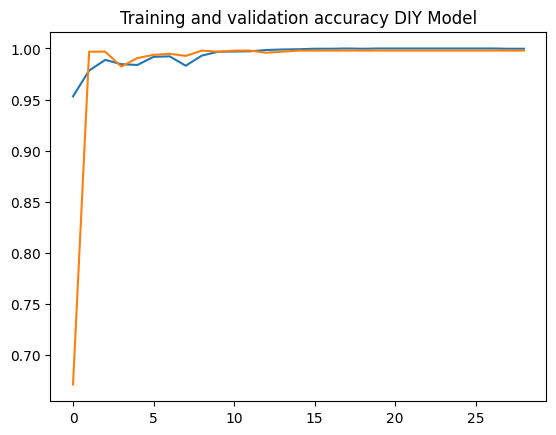

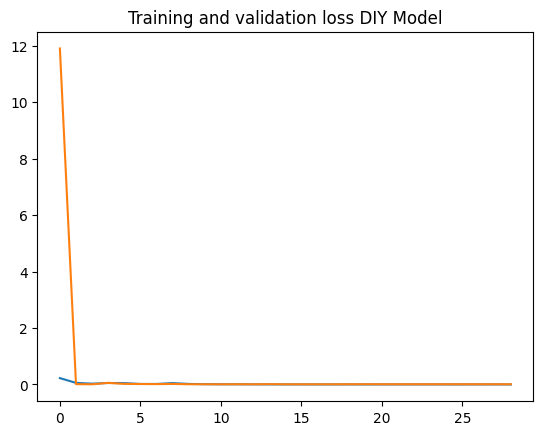

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_1.history['accuracy' ]
val_acc  = history_DenseNet_model_1.history['val_accuracy' ]
loss     = history_DenseNet_model_1.history['loss' ]
val_loss = history_DenseNet_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

## DenseNet Model 2

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="BellPaper_DenseNet_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define DIY Model
DenseNet_model_2 = tf.keras.models.Sequential([
    # DenseNet121 Layer
    DenseNet121(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(2, activation='softmax') 
  ])


# Compile Model
DenseNet_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
DenseNet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 7,300,418
Trainable params: 7,216,770
Non-trainable params: 83,648
_______________________________________

In [15]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_DenseNet_model_2 = DenseNet_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
202/202 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9561
Epoch 1: val_accuracy improved from -inf to 0.91372, saving model to BellPaper_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


202/202 [==============================] - 86s 375ms/step - loss: 0.1331 - accuracy: 0.9561 - val_loss: 0.5091 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 2/100
202/202 [==============================] - ETA: 0s - loss: 0.0655 - accuracy: 0.9774
Epoch 2: val_accuracy improved from 0.91372 to 0.97817, saving model to BellPaper_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


202/202 [==============================] - 77s 383ms/step - loss: 0.0655 - accuracy: 0.9774 - val_loss: 0.0830 - val_accuracy: 0.9782 - lr: 0.0010
Epoch 3/100
202/202 [==============================] - ETA: 0s - loss: 0.0454 - accuracy: 0.9856
Epoch 3: val_accuracy improved from 0.97817 to 0.98753, saving model to BellPaper_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


202/202 [==============================] - 76s 373ms/step - loss: 0.0454 - accuracy: 0.9856 - val_loss: 0.0462 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 4/100
202/202 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9866
Epoch 4: val_accuracy did not improve from 0.98753
202/202 [==============================] - 36s 178ms/step - loss: 0.0339 - accuracy: 0.9866 - val_loss: 0.1337 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 5/100
202/202 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9849
Epoch 5: val_accuracy improved from 0.98753 to 0.99584, saving model to BellPaper_DenseNet_model2_Based_Non_Augmented


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


202/202 [==============================] - 75s 374ms/step - loss: 0.0437 - accuracy: 0.9849 - val_loss: 0.0098 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 6/100
202/202 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9836
Epoch 6: val_accuracy did not improve from 0.99584
202/202 [==============================] - 36s 177ms/step - loss: 0.0497 - accuracy: 0.9836 - val_loss: 0.0258 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 7/100
202/202 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9913
Epoch 7: val_accuracy did not improve from 0.99584
202/202 [==============================] - 36s 180ms/step - loss: 0.0248 - accuracy: 0.9913 - val_loss: 0.0762 - val_accuracy: 0.9751 - lr: 0.0010
Epoch 8/100
202/202 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9931
Epoch 8: val_accuracy did not improve from 0.99584
202/202 [==============================] - 38s 188ms/step - loss: 0.0197 - accuracy: 0.9931 - val_loss: 0.0656 - va

INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


INFO:tensorflow:Assets written to: BellPaper_DenseNet_model2_Based_Non_Augmented\assets


202/202 [==============================] - 78s 387ms/step - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.0031 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 12/100
202/202 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9948
Epoch 12: val_accuracy did not improve from 0.99896
202/202 [==============================] - 37s 180ms/step - loss: 0.0138 - accuracy: 0.9948 - val_loss: 0.0037 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 13/100
202/202 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9958
Epoch 13: val_accuracy did not improve from 0.99896
202/202 [==============================] - 37s 182ms/step - loss: 0.0094 - accuracy: 0.9958 - val_loss: 0.0033 - val_accuracy: 0.9990 - lr: 1.0000e-04
Epoch 14/100
202/202 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9973
Epoch 14: val_accuracy did not improve from 0.99896
202/202 [==============================] - 37s 185ms/step - loss: 0.0093 - accuracy: 0.9973 - val

Text(0.5, 1.0, 'Training and validation loss DIY Model')

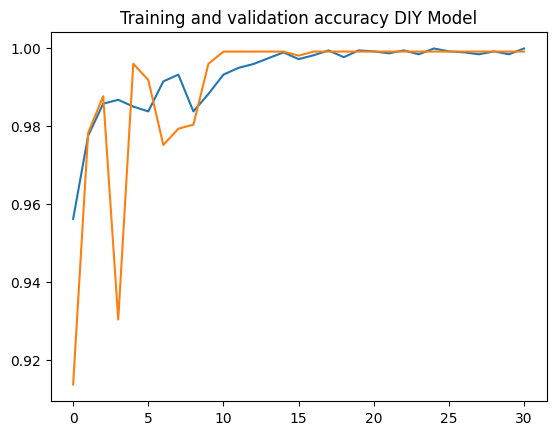

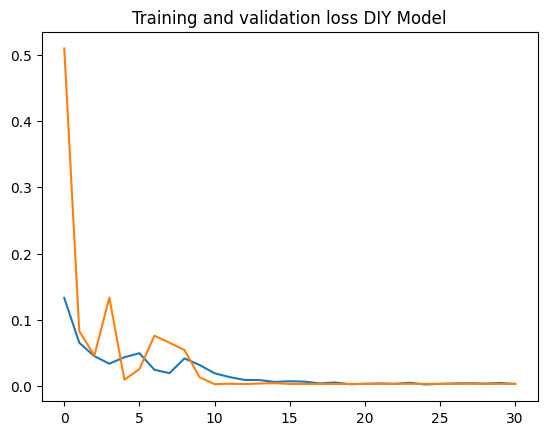

In [16]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_DenseNet_model_2.history['accuracy' ]
val_acc  = history_DenseNet_model_2.history['val_accuracy' ]
loss     = history_DenseNet_model_2.history['loss' ]
val_loss = history_DenseNet_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')